<h1><center>Milan's Users Celullar Traffic Predicction</center></h1>

In [2]:
# pip install --upgrade tensorflow==1.15.0

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from six.moves import cPickle as pickle
from sklearn.preprocessing import StandardScaler
import datetime
import os

In [3]:
if False or not os.path.exists('data.pickle'):
    parse = lambda x: datetime.datetime.fromtimestamp(float(x) / 1000)
    # https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/UTLAHU
    sliceSum = pd.DataFrame({})
    for index in range(1,42):
        sliceSum2 = (pd.read_csv('Milan_Data/sms-call-internet-mi-2013-11-'+str(index).zfill(2) +'.txt', sep='\t',
                                 encoding="utf-8-sig", names=['CellID', 'datetime', 'countrycode', 'smsin', 'smsout',
                                                              'callin', 'callout', 'internet'], parse_dates=['datetime']
                                 , date_parser=parse))
        sliceSum2 = sliceSum2.set_index('datetime')
        # sliceSum2 = (sliceSum2[(sliceSum2['CellID'] == 1) | (sliceSum2['CellID'] == 2) | (sliceSum2['CellID'] == 101)
        #                        | (sliceSum2['CellID'] == 102)])
        sliceSum2 = sliceSum2.groupby(['datetime'], as_index=True).sum()
        sliceSum2['hour'] = sliceSum2.index.hour
        sliceSum2['weekday'] = sliceSum2.index.weekday
        sliceSum = sliceSum.append(sliceSum2)

    data =sliceSum[['smsin', 'smsout', 'callin', 'callout', 'internet']].fillna(0)

    # Escalado de datos
#     scaled_data = StandardScaler().fit_transform(data)
    pickle_file = open('data.pickle', 'wb')
    pickle.dump(data, pickle_file)
    pickle_file.close()

extract_data = open('data.pickle', 'rb')
data = pickle.load(extract_data)

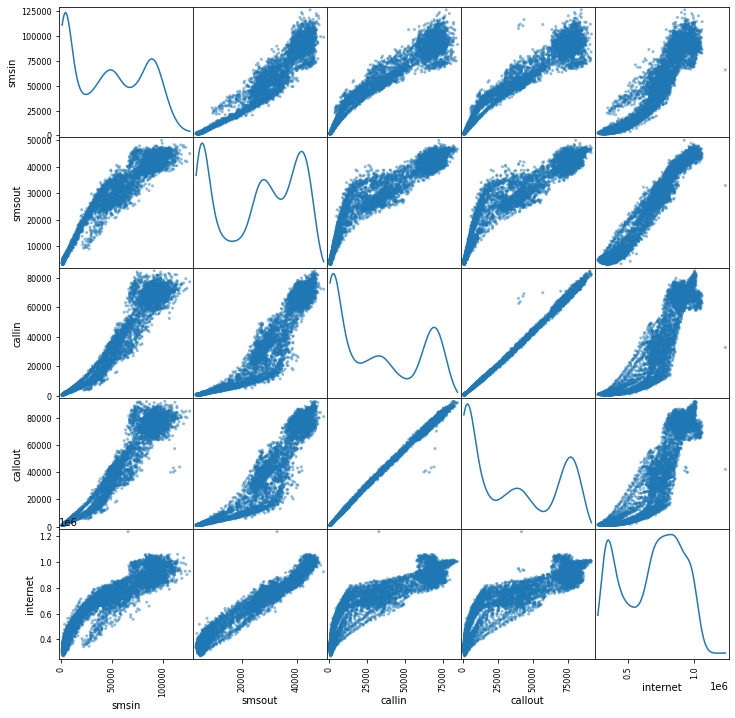

In [4]:
from pandas.plotting import scatter_matrix

scatter_matrix(data, figsize = (12, 12), diagonal = 'kde');
plt.show()

In [5]:
##########################################ELIMINACION VARIABLES COLINEALES##############################################


from sklearn.linear_model import LinearRegression

def calculateVIF(data):
    features = list(data.columns)
    num_features = len(features)

    model = LinearRegression()

    result = pd.DataFrame(index=['VIF'], columns=features)
    result = result.fillna(0)

    for ite in range(num_features):
        x_features = features[:]
        y_featue = features[ite]
        x_features.remove(y_featue)

        x = data[x_features]
        y = data[y_featue]

        model.fit(data[x_features], data[y_featue])

        result[y_featue] = 1 / (1 - model.score(data[x_features], data[y_featue]))
        
    return result

# Se considera una milticolinealidad alta si VIF > 10. Restringimos a 8
def selectDataUsingVIF(data, max_VIF=8):
    result = data.copy(deep=True)

    VIF = calculateVIF(result)

    while VIF.to_numpy().max() > max_VIF:
        col_max = np.where(VIF == VIF.to_numpy().max())[1][0]
        features = list(result.columns)
        features.remove(features[col_max])
        result = result[features]

        VIF = calculateVIF(result)

    return result


model_vars = selectDataUsingVIF(data)
#print('Las variables seleccionadas para el modelo según VIF son: ', list(model_vars.columns))
calculateVIF(model_vars)
# No se obtiene alta colinealidad en ningua de las variables

,callin,internet
VIF,5.423179,5.423179


In [8]:
# data = data[['smsin', 'smsout', 'callin', 'internet']]
scaled_data = StandardScaler().fit_transform(data)

In [10]:
# Hyperparameters
slide_window = 84 #84
batch_size = slide_window*2
nodes = 32
learning_rate = 0.0005
sample_pred = 10 # número de dias a predecir
epochs = 10
Layers = 3

In [13]:
# Los datos de training son divisibles por la ventana
Len_train = 0.6*len(scaled_data)
Sub = Len_train % slide_window
if Sub != 0:
    Len_train = Len_train - Sub

Train_data = scaled_data[:math.ceil(Len_train)] #60% de los datos
Rest_data = scaled_data[math.ceil(Len_train):] # 40% de los datos
Validation_data = Rest_data[:math.ceil(len(Rest_data)/2)]# 20% de los datos
Test_data = Rest_data[math.ceil(len(Rest_data)/2):]# 20% de los datos

# Ventana deslizante
def reformat(data, slide_window):
    X = []
    Y = []

    i = 0
    while (i + slide_window) <= len(data) - 1 - sample_pred:
        X.append(data[i:i + slide_window])
        temp = np.array(data[i + sample_pred + slide_window - 1,3])
        temp.shape = (1,)
        Y.append(temp)
        i += 1
    return X, Y

In [14]:
# Dataset creado
X_train, y_train = reformat(Train_data, slide_window)
X_test, y_test = reformat(Test_data, slide_window)
X_validation, Y_validation = reformat(Validation_data, slide_window)

X_train = np.array(X_train)
Y_train = np.array(y_train)
X_validation = np.array(X_validation)
Y_validation = np.array(Y_validation)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [15]:
# definicion de la red
graph = tf.Graph()
with graph.as_default():

    #placeholders
    inputs = tf.placeholder(tf.float32, [batch_size, slide_window, 5])
    targets = tf.placeholder(tf.float32, [batch_size, 1])
    #pesos de salida y bias
    w_o = tf.Variable(tf.truncated_normal([nodes, 1], stddev=0.05))
    b_ol = tf.Variable(tf.zeros([1]))

    # Modelo LSTM
    #https://www.tensorflow.org/tutorials/sequences/recurrent #Apache License 2.0
    def lstm_cell():                                                            #
        return tf.contrib.rnn.BasicLSTMCell(nodes)                              #
                                                                                #
    stacked_lstm = tf.contrib.rnn.MultiRNNCell(
        [lstm_cell() for _ in range(Layers)])                                   #
                                                                                #
    initial_state = state = stacked_lstm.zero_state(batch_size, tf.float32)     #
    for i in range(slide_window):                                               #
        output, state = stacked_lstm(inputs[:, i], state)                       #
    #############################################################################
    outputs = []
    i = 0
    for i in range(batch_size ):
        outputs.append(tf.nn.xw_plus_b(tf.reshape(output[i], (1, nodes)), w_o, b_ol))

    # MSE
    loss = tf.reduce_mean(
        tf.losses.mean_squared_error(
            targets, tf.concat(outputs, 0)))

    # MSE relativo
    error = tf.losses.mean_squared_error(targets, tf.concat(outputs, 0)) / targets
    mse_r = 100*tf.reduce_mean(error)

    # Optimizado
    gradients = tf.gradients(loss, tf.trainable_variables())
    optimizer = tf.train.AdamOptimizer(learning_rate)
    trained_optimizer = optimizer.apply_gradients(zip(gradients, tf.trainable_variables()))

    init_g = tf.global_variables_initializer()
    init_l = tf.local_variables_initializer()

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 0/10  Training loss: 0.9518505334854126  Validation MSE: 0.84  Validation MSE Relative: 785.71%
Epoch 1/10  Training loss: 0.8005732297897339  Validation MSE: 0.68  Validation MSE Relative: 674.51%
Epoch 2/10  Training loss: 0.5884312987327576  Validation MSE: 0.41  Validation MSE Relative: 393.14%
Epoch 3/10  Training loss: 0.3282337188720703  Validation MSE: 0.23  Validation MSE Relative: 148.51%
Epoch 4/10  Training loss: 0.2528429627418518  Validation MSE: 0.18  Validation MSE Relative: 130.47%
Epoch 5/10  Training loss: 0.2085299789905548  Validation MSE: 0.17  Validation MSE Relative: 122.65%
Epoch 6/10  Training loss: 0.16575708985328674  Validation MSE: 0.15  Validation MSE Relative: 112.41%
Epoch 7/10  Training loss: 0.13425804674625397  Validation MSE: 0.14  Validation MSE Relative: 96.66%
Epoch 8/10  Training loss: 0.11548446118831635  Validation MSE: 0.12  Validation MSE Relative: 93.92%
Epoch 9/10  Training loss: 0.09525272250175476  Validation MSE: 0.10  Validation 

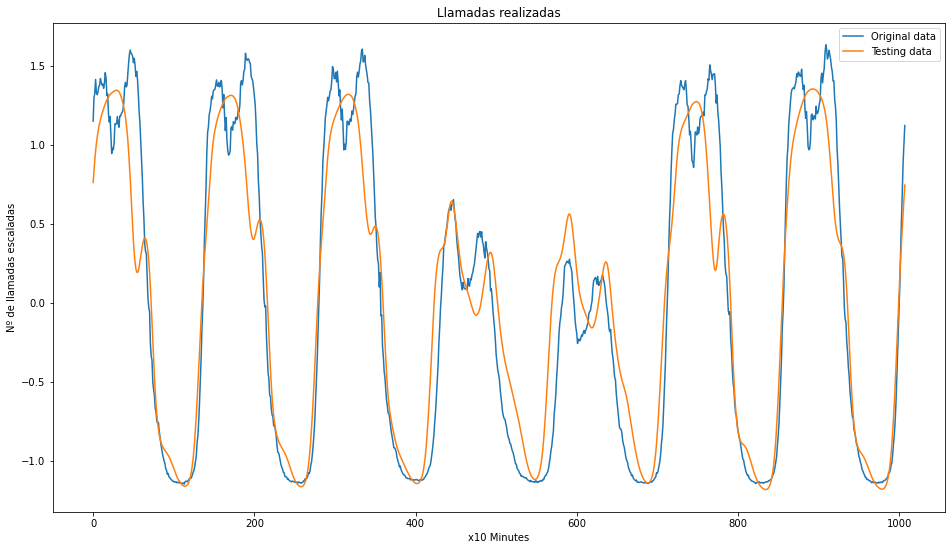

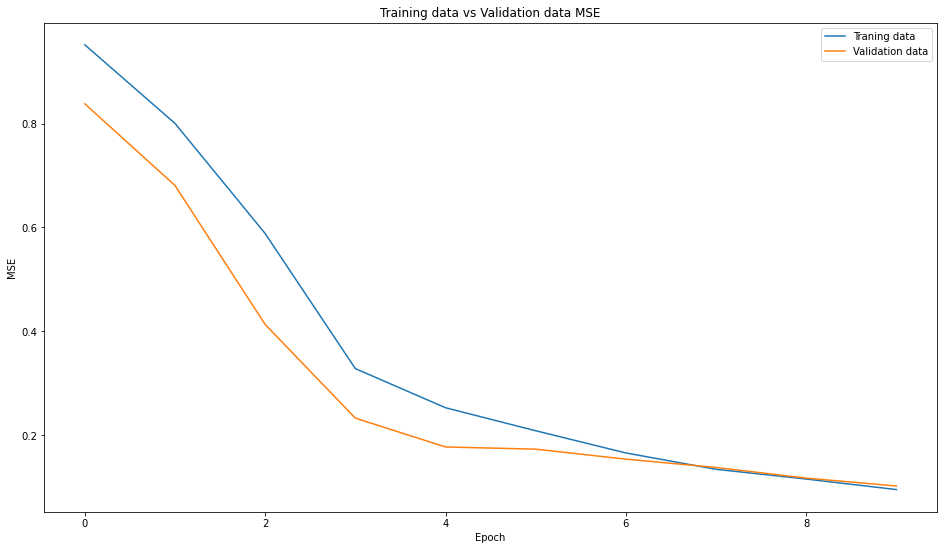

In [16]:
with tf.Session(graph=graph) as session:
    session.run(init_g)
    session.run(init_l)

    Lossplot = []
    Lossplotvalid = []
    for j in range(epochs):
        outs = []
        scores = []
        epoch_loss = []
        i = 0
        # Entrenamiento
        while (i + batch_size) <= len(X_train):
            X_batch = X_train[i:i + batch_size]
            y_batch = y_train[i:i + batch_size]
            feed_dict = {inputs: X_batch, targets: y_batch}
            out, perd, _ = session.run([outputs, loss, trained_optimizer], feed_dict=feed_dict)
            outs.extend(out)
            epoch_loss.append(perd)
            i += batch_size
        epoch_loss = np.mean(epoch_loss)
        Lossplot.append(epoch_loss)

        validation = []
        valid_loss = []
        MRE = []
        i = 0
        # Validación
        while i + batch_size <= len(X_validation):
            feed_dict = {inputs: X_validation[i:i + batch_size], targets: Y_validation[i:i + batch_size]}
            out, l, mre = session.run([outputs, loss, mse_r], feed_dict=feed_dict)
            MRE.append(mre)
            valid_loss.append(l)
            validation.extend(out)
            i += batch_size
        valid_loss = np.mean(valid_loss)
        MRE = np.mean(MRE)
        Lossplotvalid.append(valid_loss)
        print('Epoch {}/{}'.format(j, epochs), ' Training loss: {}'.format(np.mean(epoch_loss)),
              " Validation MSE: %.2f" % valid_loss, " Validation MSE Relative: %.2f%%" % abs(MRE))

    MSEr_test = []
    test_loss = []
    test = []
    i = 0
    # Test
    while i + batch_size <= len(X_test):
        feed_dict = {inputs: X_test[i:i + batch_size], targets: y_test[i:i + batch_size]}
        out, MSE, MSEr = session.run([outputs, loss, mse_r], feed_dict=feed_dict)
        MSEr_test.append(MSEr)
        test_loss.append(MSE)
        test.extend(out)
        i += batch_size
    test_loss = np.mean(test_loss)
    MSErtest = np.mean(MSEr_test)
    print('Epoch {}/{}'.format(j, epochs), " Test MSE: %.4f" % test_loss, " Test MSE Relative: %.4f%%" % abs(MSErtest))

    tests = []
    i = 0
    while i <= len(test) - 1:
        tests.extend(np.reshape(test[i], (len(test[i]))))
        i += 1

    plt.figure(num='Prediction', figsize=(16, 9))
    plt.title('Llamadas realizadas')
    plt.xlabel('x10 Minutes')
    plt.ylabel('Nº de llamadas escaladas')

    # Ploteado de datos Originales y datos de test
    plt.plot(y_test[:len(tests)], label='Original data')
    plt.plot(tests, label='Testing data')
    plt.legend()
    plt.show()

    # Ploteado MSE
    plt.figure(num='MSE', figsize=(16, 9))
    plt.title('Training data vs Validation data MSE')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.plot(Lossplot, label='Traning data')
    plt.plot(Lossplotvalid, label='Validation data')
    plt.legend()
    plt.show()